# ✅ Step 1 – Google Drive Bağlantısı ve Kütüphanelerin Yüklenmesi

In [3]:
!pip install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.6 MB/s eta 0:00:00


In [4]:
# 📌 Gerekli kütüphaneler
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step 1 – Gerekli Kütüphanelerin Yüklenmesi ve Google Drive Bağlantısı

Bu adımda proje için gereken tüm Python kütüphaneleri yüklenir ve Google Colab ortamı üzerinden Google Drive'a bağlantı kurulur:

- **Google Drive Bağlantısı:**
  - `drive.mount('/content/drive')` komutu ile Google Drive'a bağlanılır.
  - Veri dosyalarına Drive üzerinden erişim sağlanır.

- **Veri İşleme ve Görselleştirme:**
  - `pandas`: CSV dosyalarını okumak ve düzenlemek için kullanılır.
  - `matplotlib.pyplot` ve `numpy`: görselleştirme ve sayısal işlemler için kullanılır.

- **Makine Öğrenimi ve Derin Öğrenme:**
  - `torch`: PyTorch kütüphanesi, tensör işlemleri ve model eğitimi için kullanılır.
  - `torch.nn` ve `torch.nn.functional`: katmanlar ve aktivasyon fonksiyonları gibi neural network bileşenlerini içerir.
  - `sklearn.metrics`: performans ölçütleri olan AUC, doğruluk ve F1 skorunu hesaplamak için kullanılır.

- **Graf Sinir Ağları (GNN):**
  - `torch_geometric.data.Data`: grafik verilerini temsil etmek için kullanılır.
  - `torch_geometric.nn`: PyTorch Geometric içinde yer alan GNN katmanları (`SAGEConv`, `GCNConv`) bu projede kullanılacaktır.

# ✅ Step 2 – Verilerin Yüklenmesi ve Ön Hazırlık


In [5]:
# 📁 Dosya yolu
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/social-datasets/"

# 1. Verileri Yükle
node_features_df = pd.read_csv(DATA_PATH + "node_features_sampled.csv", header=None)
node_features_df.columns = ["node_id", "feat1", "feat2", "feat3", "feat4", "feat5", "feat6", "feat7", "feat8"]
node_features_df.replace(-1, 0, inplace=True)

edges_train_df = pd.read_csv(DATA_PATH + "edges_train_A.csv", header=None)
edges_train_df.columns = ["source_node", "target_node", "edge_type", "timestamp"]

input_df = pd.read_csv(DATA_PATH + "input_A.csv", header=None)
input_df.columns = ["src", "dst", "edge_type", "start", "end", "label"]
input_df["timestamp"] = ((input_df["start"] + input_df["end"]) / 2).astype(int)


### Step 2 – Verilerin Yüklenmesi ve Ön İşleme

Bu adımda Google Drive'daki veri dosyaları okunur ve model için uygun hale getirilir:

- **`DATA_PATH`**: Google Drive’daki veri klasörünün yolu tanımlanır.

#### 1. `node_features_sampled.csv`:
- Her düğümün sahip olduğu özellikleri (feature) içerir.
- Dosyada başlık olmadığı için manuel olarak sütun adları verilir.
- `-1` ile ifade edilen eksik veriler `0` ile değiştirilir. Bu, GNN’in daha istikrarlı öğrenmesini sağlar.

#### 2. `edges_train_A.csv`:
- Eğitim grafiğindeki bağlantıları içerir.
- Her bağlantı; kaynak düğüm (`source_node`), hedef düğüm (`target_node`), bağlantı türü (`edge_type`) ve zaman damgası (`timestamp`) içerir.

#### 3. `input_A.csv`:
- Modelin tahmin yapacağı test bağlantılarını içerir.
- Her satır, iki düğüm arasındaki olası bağlantıyı temsil eder.
- Başlangıç ve bitiş zamanlarının ortalaması alınarak tahmin için kullanılacak bir `timestamp` sütunu eklenir. Bu, bağlantının hangi zaman aralığında olup olmadığını modelin anlamasına yardımcı olur.


# ✅ Step 3 – Node ID Mapping ve Tensor Oluşturma

In [28]:

# 2. Node ID Map (mapping for all IDs)
all_node_ids = pd.concat([
    node_features_df["node_id"],
    edges_train_df["source_node"],
    edges_train_df["target_node"],
    input_df["src"],
    input_df["dst"]
]).drop_duplicates().astype(int)

node_id_map = {old_id: new_id for new_id, old_id in enumerate(sorted(all_node_ids))}
print(f"Toplam düğüm sayısı: {len(node_id_map)}")

# 3. Mapping uygulama
node_features_df["node_index"] = node_features_df["node_id"].map(node_id_map)
node_features_df = node_features_df.dropna(subset=["node_index"])
node_features_df["node_index"] = node_features_df["node_index"].astype(int)
node_features_df = node_features_df.sort_values("node_index").reset_index(drop=True)

features = node_features_df.drop(columns=["node_id", "node_index"]).values
scaler = StandardScaler()
features = scaler.fit_transform(features)
x = torch.tensor(features, dtype=torch.float)

# Eksik node'lar için padding
num_total_nodes = len(node_id_map)
if x.shape[0] < num_total_nodes:
    pad = torch.zeros((num_total_nodes - x.shape[0], x.shape[1]))
    x = torch.cat([x, pad], dim=0)

edges_train_df["src_mapped"] = edges_train_df["source_node"].map(node_id_map)
edges_train_df["dst_mapped"] = edges_train_df["target_node"].map(node_id_map)
edge_index = torch.tensor(edges_train_df[["src_mapped", "dst_mapped"]].values.T, dtype=torch.long)

input_df["src_mapped"] = input_df["src"].map(node_id_map)
input_df["dst_mapped"] = input_df["dst"].map(node_id_map)
edge_pairs = torch.tensor(input_df[["src_mapped", "dst_mapped"]].values, dtype=torch.long)

Toplam düğüm sayısı: 19442


### Step 3 – Düğüm ID Mapping, Özellik Tensor'u ve Edge Tensor'larının Hazırlanması

Bu adımda model için gerekli olan veri yapıları hazırlanır:

---

#### 🔹 1. Node ID Mapping (`node_id_map`)
- Eğitim ve test verisindeki tüm düğüm ID'leri birleştirilerek benzersiz hale getirilir (`drop_duplicates()`).
- Her düğümün orijinal ID'si, sıfırdan başlayarak yeniden indekslenir.
- Bu işlem grafik verisinin uyumlu ve kompakt temsilini sağlamak için gereklidir.

---

#### 🔹 2. Node Features Tensor'u (`x`)
- `node_id_map` kullanılarak `node_features_df` içerisindeki düğümler yeniden indekslenir (`node_index`).
- `StandardScaler()` ile düğüm özellikleri normalize edilir (ortalama 0, standart sapma 1).
- NumPy array'den PyTorch tensor'a (`x`) dönüştürülür.

> 💡 **Padding işlemi:** Eğer bazı düğümler için özellik vektörü eksikse, bunlar sıfır vektör ile doldurulur. Böylece düğüm sayısı ile tensor satır sayısı eşit olur.

---

#### 🔹 3. Edge Tensor'larının Hazırlanması
- Eğitim verisindeki bağlantılar (`edges_train_df`) yeniden indekslenmiş düğüm ID'lerine (`src_mapped`, `dst_mapped`) dönüştürülür.
- Bu çiftler `edge_index` tensor’unda tutulur (PyTorch Geometric formatı gereği `shape = [2, num_edges]`).
- Aynı şekilde, test verisindeki tahmin yapılacak bağlantı çiftleri `edge_pairs` tensor’unda tutulur.

> 🎯 Bu tensor'lar modelin grafik yapısını anlaması ve test için bağlantı tahmini yapabilmesi adına kritik önemdedir.


# ✅ Step 4 – Model Tanımlamaları (GCN & GraphSAGE)

In [29]:
# PyG Graph
data = Data(x=x, edge_index=edge_index)

# 🔧 MODELLER
class SAGEModel(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels * 2, 1)

    def forward(self, x, edge_index, edge_pairs):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        src = x[edge_pairs[:, 0]]
        dst = x[edge_pairs[:, 1]]
        return torch.sigmoid(self.lin(torch.cat([src, dst], dim=1))).squeeze()

class GCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels * 2, 1)

    def forward(self, x, edge_index, edge_pairs):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        src = x[edge_pairs[:, 0]]
        dst = x[edge_pairs[:, 1]]
        return torch.sigmoid(self.lin(torch.cat([src, dst], dim=1))).squeeze()

### Step 4 – PyTorch Geometric Veri Yapısı ve GNN Model Tanımlamaları

---

#### 🧱 1. PyG Graph Tanımı (`data`)
- PyTorch Geometric için özel bir grafik veri yapısı (`Data`) tanımlanır.
- `x`: Her düğümün özelliklerini içeren tensor (shape: `[num_nodes, num_features]`)
- `edge_index`: Grafikteki yönlü bağlantıları içeren tensor (shape: `[2, num_edges]`)

Bu yapı modelin öğrenebilmesi için temel girdidir.

---

#### 🧠 2. GraphSAGE Modeli (`SAGEModel`)
- GraphSAGE (Sample and Aggregate) yapısına uygun olarak iki adet `SAGEConv` katmanı içerir.
- Her düğümün embedding'i, komşularının bilgilerini toplayarak güncellenir.
- Son katmanda `src` ve `dst` düğümlerinin embedding’leri birleştirilip (`concat`) doğrultu (`sigmoid`) çıkışına aktarılır.
- Bu çıkış 0–1 arası bağlantı olasılığıdır.

---

#### 🧠 3. GCN Modeli (`GCNModel`)
- Geleneksel Graph Convolutional Network (GCN) yapısıdır.
- Yine iki konvolüsyon katmanı kullanılır (`GCNConv`).
- GraphSAGE ile aynı mantıkta çalışır: `src` ve `dst` düğümlerinin embedding'leri birleştirilerek çıkış alınır.

---

🔍 Her iki model de bağlantı tahmini (link prediction) amacıyla kullanılır.  
Modelin çıktısı, iki düğüm arasında bağlantı olma olasılığıdır.

> Fark:  
> - **SAGEConv**: Düğüm özelliklerini doğrudan komşulardan toplar (aggregate).  
> - **GCNConv**: Komşuluk yapısını normalize ederek bilgi yayılımı yapar.

Bu iki model karşılaştırılarak hangisinin daha başarılı olduğu analiz edilecektir.


# ✅ Step 5 – Model Eğitimi ve Threshold Optimizasyonu

In [45]:
# 🔁 Eğitim ve Tahmin Fonksiyonu (Loss çizimi + threshold optimizasyonlu)
def train_and_evaluate(model_class, model_name):
    model = model_class(in_channels=data.num_features, hidden_channels=64).to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

    losses = []  # 🔹 Loss değerlerini burada toplayacağız

    for epoch in range(100):
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, edge_pairs)
        loss = F.binary_cross_entropy(output, true_labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())  # 🔹 Her epoch'ta loss kaydı
        print(f"[{model_name}] Epoch {epoch}, Loss: {loss.item():.4f}")

    # 🔹 Loss grafiği çizimi
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 4))
    plt.plot(losses, label=f"{model_name} Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Loss Eğrisi")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    model.eval()
    with torch.no_grad():
        probs = model(data.x, data.edge_index, edge_pairs).cpu().numpy()

    # 🔍 Threshold optimizasyonu
    best_f1, best_thresh = 0, 0.5
    for t in np.linspace(0.1, 0.9, 50):
        preds = (probs >= t).astype(int)
        f1 = f1_score(true_labels_cpu, preds)
        if f1 > best_f1:
            best_f1, best_thresh = f1, t

    pred_labels = (probs >= best_thresh).astype(int)
    auc = roc_auc_score(true_labels_cpu, probs)
    acc = accuracy_score(true_labels_cpu, pred_labels)

    print(f"\n[{model_name}] AUC: {auc:.4f} | Accuracy: {acc:.4f} | F1: {best_f1:.4f} | Best Threshold: {best_thresh:.2f}")
    return model, probs, auc, acc, best_f1


### Step 5 – Model Eğitimi, Tahmin ve Threshold Optimizasyonu

Bu adımda bir fonksiyon tanımlanır: `train_and_evaluate()`.  
Verilen model sınıfını eğitir, tahmin üretir ve en iyi eşik değerini (`threshold`) optimize ederek performans metriklerini hesaplar.

---

#### 🔁 1. Model Eğitimi
- `model_class`: GraphSAGE veya GCN olabilir.
- Model oluşturulur ve GPU varsa `cuda`'ya atanır.
- 100 epoch boyunca model eğitilir:
  - Tahminler alınır.
  - Binary Cross Entropy (BCE) loss hesaplanır.
  - Geri yayılım (`loss.backward()`) ile ağırlıklar güncellenir.

> 🔔 Her 20 epoch’ta bir loss değeri yazdırılır.

---

#### 📈 2. Tahmin ve Threshold Aralığı Taraması
- Model değerlendirme moduna alınır (`model.eval()`).
- `probs`: Her test bağlantısı için bağlantı olasılığı (0–1 arası değer).
- Bu olasılıklar kullanılarak en iyi `threshold` değeri bulunur:
  - 0.1 ile 0.9 arasında 50 farklı eşik değeri denenir.
  - Her eşikte F1 skoru hesaplanır.
  - En yüksek F1 değerine sahip threshold seçilir.

> 🎯 Bu adım, sınıflar arasında dengesizlik olduğunda modelin performansını iyileştirmek için çok önemlidir.

---

#### ✅ 3. Metriklerin Hesaplanması
- **AUC**: Modelin bağlantı tahmin başarısı (olasılık kalitesi).
- **Accuracy**: Doğru tahmin edilen bağlantıların oranı.
- **F1**: Precision ve Recall dengesine göre hesaplanan puan.
- En iyi eşik değeri ile etiketler (`pred_labels`) hesaplanır.

---

#### 🔚 Fonksiyonun Çıkışı
- Eğitilmiş model
- Tahmin edilen olasılıklar (`probs`)
- AUC, Accuracy, F1 skorları

> Bu yapı sayesinde her model için tutarlı şekilde hem eğitim hem de değerlendirme yapılır.


# ✅ Step 6 – Model Karşılaştırması

In [46]:
# 📊 Model Karşılaştırması Başlat
true_labels = torch.tensor(input_df["label"].values, dtype=torch.float, device=device)
true_labels_cpu = input_df["label"].values
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)
edge_pairs = edge_pairs.to(device)

results = {}

### Step 6 – Model Karşılaştırması İçin Ortamın Hazırlanması

Bu adımda, modelleri çalıştırmadan önce eğitim ve test işlemleri için gerekli ortam oluşturulur:

---

#### 🎯 1. Gerçek Etiketlerin (True Labels) Tensor Haline Getirilmesi
- `true_labels`: Test verisindeki etiketler (`label`) PyTorch tensor'üne dönüştürülür. Bu, model eğitimi sırasında kullanılır.
- `true_labels_cpu`: Aynı etiketler NumPy array olarak tutulur. Sklearn ile metrik hesaplamaları yapılırken bu format kullanılır (örneğin: `f1_score`, `roc_auc_score`).

---

#### ⚙️ 2. Donanım Kontrolü
- `torch.device(...)`: GPU varsa model eğitimi GPU üzerinde yapılır, yoksa CPU kullanılır.
- `data.to(device)`: Tüm grafik verisi (düğüm bilgileri ve bağlantılar) uygun cihaza taşınır.
- `edge_pairs.to(device)`: Test bağlantı çiftleri de aynı şekilde cihaza aktarılır.

---

#### 📦 3. Sonuçları Saklamak İçin Sözlük
- `results = {}`: Her modelin AUC ve doğruluk (accuracy) skorlarını bu sözlükte saklayacağız.
- Böylece modelleri çalıştırdıktan sonra tüm skorları kolayca karşılaştırabilir ve görselleştirebiliriz.

> Bu hazırlık adımı sayesinde modeller arasında adil bir karşılaştırma yapılabilecek ortam oluşturulmuş olur.


# ✅ Step 7 – Modellerin Sonuç Skorları

[GraphSAGE] Epoch 0, Loss: 0.6902
[GraphSAGE] Epoch 1, Loss: 2.9869
[GraphSAGE] Epoch 2, Loss: 2.2756
[GraphSAGE] Epoch 3, Loss: 1.1237
[GraphSAGE] Epoch 4, Loss: 0.7227
[GraphSAGE] Epoch 5, Loss: 0.6964
[GraphSAGE] Epoch 6, Loss: 0.7094
[GraphSAGE] Epoch 7, Loss: 0.7204
[GraphSAGE] Epoch 8, Loss: 0.7219
[GraphSAGE] Epoch 9, Loss: 0.7166
[GraphSAGE] Epoch 10, Loss: 0.7088
[GraphSAGE] Epoch 11, Loss: 0.7029
[GraphSAGE] Epoch 12, Loss: 0.7020
[GraphSAGE] Epoch 13, Loss: 0.7064
[GraphSAGE] Epoch 14, Loss: 0.7111
[GraphSAGE] Epoch 15, Loss: 0.7088
[GraphSAGE] Epoch 16, Loss: 0.6994
[GraphSAGE] Epoch 17, Loss: 0.6902
[GraphSAGE] Epoch 18, Loss: 0.6891
[GraphSAGE] Epoch 19, Loss: 0.6952
[GraphSAGE] Epoch 20, Loss: 0.6991
[GraphSAGE] Epoch 21, Loss: 0.6970
[GraphSAGE] Epoch 22, Loss: 0.6917
[GraphSAGE] Epoch 23, Loss: 0.6881
[GraphSAGE] Epoch 24, Loss: 0.6882
[GraphSAGE] Epoch 25, Loss: 0.6894
[GraphSAGE] Epoch 26, Loss: 0.6866
[GraphSAGE] Epoch 27, Loss: 0.6831
[GraphSAGE] Epoch 28, Loss: 0.

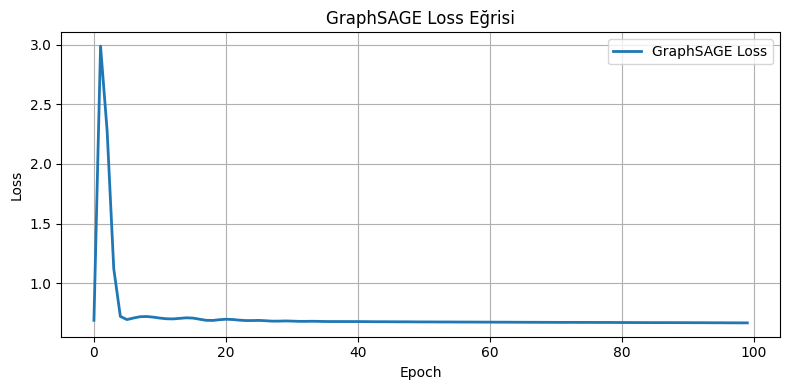


[GraphSAGE] AUC: 0.5841 | Accuracy: 0.4454 | F1: 0.6063 | Best Threshold: 0.26
[GCN] Epoch 0, Loss: 0.6884
[GCN] Epoch 1, Loss: 4.4872
[GCN] Epoch 2, Loss: 7.1720
[GCN] Epoch 3, Loss: 2.1034
[GCN] Epoch 4, Loss: 1.3488
[GCN] Epoch 5, Loss: 0.8787
[GCN] Epoch 6, Loss: 0.7252
[GCN] Epoch 7, Loss: 0.6890
[GCN] Epoch 8, Loss: 0.6887
[GCN] Epoch 9, Loss: 0.7014
[GCN] Epoch 10, Loss: 0.7205
[GCN] Epoch 11, Loss: 0.7324
[GCN] Epoch 12, Loss: 0.7234
[GCN] Epoch 13, Loss: 0.7029
[GCN] Epoch 14, Loss: 0.7015
[GCN] Epoch 15, Loss: 0.6955
[GCN] Epoch 16, Loss: 0.6828
[GCN] Epoch 17, Loss: 0.6971
[GCN] Epoch 18, Loss: 0.7071
[GCN] Epoch 19, Loss: 0.6946
[GCN] Epoch 20, Loss: 0.6882
[GCN] Epoch 21, Loss: 0.6905
[GCN] Epoch 22, Loss: 0.6850
[GCN] Epoch 23, Loss: 0.6834
[GCN] Epoch 24, Loss: 0.6904
[GCN] Epoch 25, Loss: 0.6889
[GCN] Epoch 26, Loss: 0.6834
[GCN] Epoch 27, Loss: 0.6843
[GCN] Epoch 28, Loss: 0.6839
[GCN] Epoch 29, Loss: 0.6813
[GCN] Epoch 30, Loss: 0.6832
[GCN] Epoch 31, Loss: 0.6854
[G

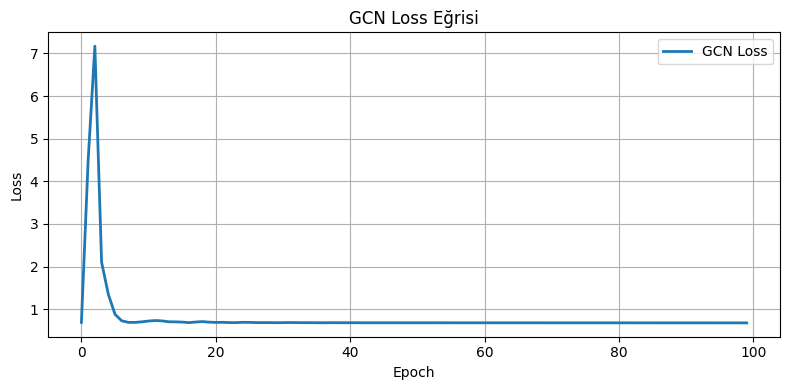


[GCN] AUC: 0.5597 | Accuracy: 0.4539 | F1: 0.6030 | Best Threshold: 0.36


In [48]:
# GraphSAGE
sage_model, sage_probs, sage_auc, sage_acc, sage_f1 = train_and_evaluate(SAGEModel, "GraphSAGE")
results["GraphSAGE"] = (sage_auc, sage_acc)

# GCN
gcn_model, gcn_probs, gcn_auc, gcn_acc, gcn_f1 = train_and_evaluate(GCNModel, "GCN")
results["GCN"] = (gcn_auc, gcn_acc)

### Step 7 – GraphSAGE ve GCN Modellerinin Eğitilmesi ve Performans Kayıtları

Bu adımda `train_and_evaluate()` fonksiyonu kullanılarak iki farklı GNN modeli eğitilir, değerlendirilir ve sonuçları karşılaştırma için kaydedilir:

---

#### 🔹 1. GraphSAGE Modeli
- `SAGEModel` sınıfı kullanılarak bir GraphSAGE modeli oluşturulur ve eğitilir.
- Eğitim sonrası modelin performans metrikleri (`AUC`, `Accuracy`, `F1`) hesaplanır.
- Bu metrikler `results` sözlüğüne `"GraphSAGE"` anahtarı ile kaydedilir.

---

#### 🔹 2. GCN Modeli
- Aynı süreç `GCNModel` sınıfı ile tekrarlanır.
- GCN modeli de eğitildikten sonra performans değerleri hesaplanır.
- Bu değerler de `results` sözlüğüne `"GCN"` etiketi ile eklenir.

---

🔍 Bu yapı sayesinde:
- Her iki model **aynı veri seti**, **aynı eğitim süreci**, **aynı değerlendirme fonksiyonu** ile eğitilip test edilir.
- Böylece doğrudan, adil bir karşılaştırma yapılabilir.

> Not: Bu karşılaştırmanın amacı hangi modelin temporal link prediction görevinde daha iyi sonuç verdiğini analiz etmektir.


# ✅ Step 8 – Model Karşılaştırma Grafiği

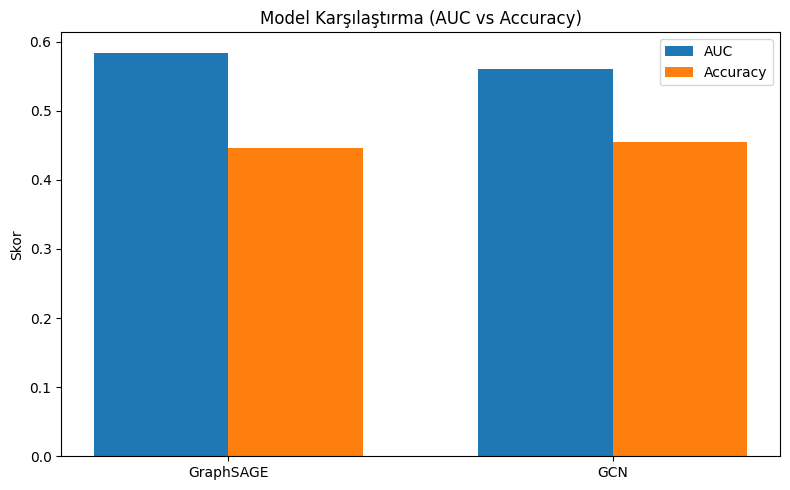

In [49]:
# 📈 Karşılaştırma Grafiği
model_names = list(results.keys())
aucs = [results[m][0] for m in model_names]
accs = [results[m][1] for m in model_names]

x = np.arange(len(model_names))
width = 0.35
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, aucs, width, label='AUC')
plt.bar(x + width/2, accs, width, label='Accuracy')
plt.xticks(x, model_names)
plt.ylabel("Skor")
plt.title("Model Karşılaştırma (AUC vs Accuracy)")
plt.legend()
plt.tight_layout()
plt.show()

### Step 8 – AUC ve Accuracy Skorlarının Görselleştirilmesi

Bu adımda GraphSAGE ve GCN modellerinin elde ettiği başarı skorları (AUC ve Accuracy) bar grafik şeklinde karşılaştırılır.

---

#### 📊 Grafik Yapısı:
- `model_names`: Karşılaştırılacak modellerin adlarını içeren liste (`["GraphSAGE", "GCN"]`)
- `aucs`: Her modelin AUC (Area Under the Curve) skoru.
- `accs`: Her modelin doğruluk (accuracy) skoru.

---

#### 🖼️ Grafik Özellikleri:
- `plt.bar(...)`: Bar grafiği çizilir.
  - AUC ve Accuracy bar'ları yan yana çizilir (solda AUC, sağda Accuracy).
- `xticks`: X ekseni, model adları ile etiketlenir.
- `ylabel`: Y ekseni “Skor” başlığı ile gösterilir.
- `title`: Grafiğin başlığı belirlenir.
- `legend`: Barların neyi temsil ettiği gösterilir.
- `tight_layout()`: Grafik yerleşimini otomatik optimize eder.

---

#### 📌 Sonuç:
Bu görsel, iki modelin başarılarını (AUC ve doğruluk) yan yana göstererek kolay yorumlanabilir bir karşılaştırma sunar.

> Bu karşılaştırma sayesinde:
> - Hangi modelin daha tutarlı ve güçlü tahminler yaptığı net biçimde görülür.
> - Raporlama ve sunumlarda grafikle anlatım daha etkileyici olur.


# ✅ Step 9 - ROC Curve (Receiver Operating Characteristic)

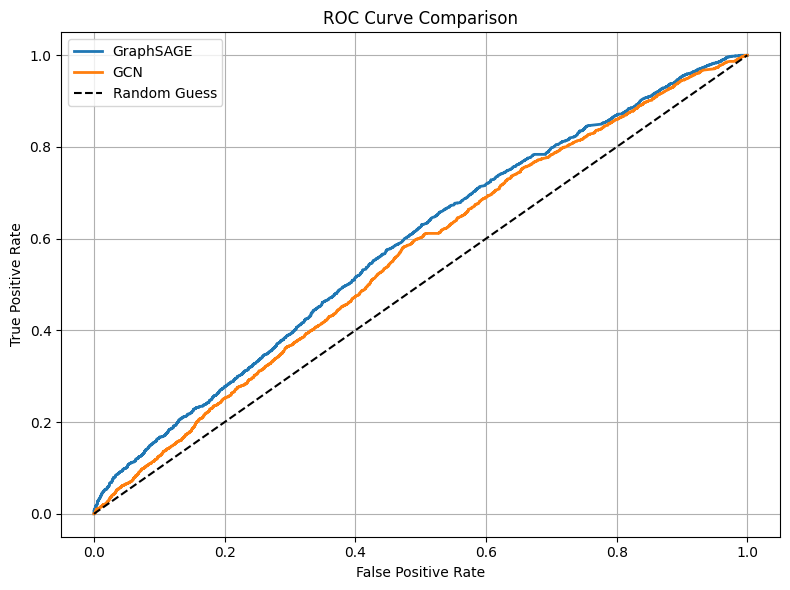

In [50]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC eğrilerini hesapla
fpr_sage, tpr_sage, _ = roc_curve(true_labels_cpu, sage_probs)
fpr_gcn, tpr_gcn, _ = roc_curve(true_labels_cpu, gcn_probs)

# ROC eğrisini çiz
plt.figure(figsize=(8, 6))
plt.plot(fpr_sage, tpr_sage, label='GraphSAGE', linewidth=2)
plt.plot(fpr_gcn, tpr_gcn, label='GCN', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### ROC Eğrisi Karşılaştırması

Bu grafik, GraphSAGE ve GCN modellerinin tüm sınıflandırma eşik değerleri üzerindeki performansını göstermektedir. ROC eğrisi, Doğru Pozitif Oranı (TPR) ile Yanlış Pozitif Oranı (FPR) arasındaki dengeyi görselleştirir. Eğrisi sol üst köşeye daha yakın olan model, sınıfları ayırt etme konusunda daha güçlü bir ayrım yeteneğine sahiptir.


# ✅ Step 10 – Sonuçları CSV Dosyasına Kaydetme

In [51]:

# 🔄 Tahminleri CSV'ye Kaydet
output_df_sage = input_df[["src", "dst", "edge_type", "start", "end"]].copy()
output_df_sage["predicted_probability"] = sage_probs
output_df_sage.to_csv(DATA_PATH + "output_A_sage.csv", index=False)

output_df_gcn = input_df[["src", "dst", "edge_type", "start", "end"]].copy()
output_df_gcn["predicted_probability"] = gcn_probs
output_df_gcn.to_csv(DATA_PATH + "output_A_gcn.csv", index=False)

print("✅ output_A_sage.csv ve output_A_gcn.csv dosyaları Drive'a kaydedildi.")


✅ output_A_sage.csv ve output_A_gcn.csv dosyaları Drive'a kaydedildi.


### Step 10 – Tahmin Sonuçlarının Kaydedilmesi (CSV Export)

Bu adımda her iki modelin (`GraphSAGE` ve `GCN`) tahmin ettiği olasılık değerleri `.csv` dosyası olarak Google Drive’a kaydedilir.

---

#### 💾 1. GraphSAGE Tahminleri (`output_A_sage.csv`)
- `input_df` içerisindeki `src`, `dst`, `edge_type`, `start`, `end` sütunları alınır.
- `sage_probs`: GraphSAGE modelinin tahmin ettiği bağlantı olasılıkları eklenir.
- Bu veriler `output_A_sage.csv` adıyla belirtilen dizine kaydedilir.

---

#### 💾 2. GCN Tahminleri (`output_A_gcn.csv`)
- Aynı yapı GCN modeli için de uygulanır.
- `gcn_probs`: GCN modelinden elde edilen olasılık tahminleri ilgili DataFrame’e eklenir.
- Sonuçlar `output_A_gcn.csv` adıyla Drive’a yazılır.

---

#### ✅ 3. Bilgilendirme
- `print(...)` komutu ile her iki dosyanın başarıyla kaydedildiği kullanıcıya bildirilir.

> Bu dosyalar daha sonra sunum, görselleştirme veya dış değerlendirme için kolayca kullanılabilir.
> Ek olarak, threshold uygulanmış tahmin etiketleri (`label`) de eklenebilir.

📂 Dosyalar Google Drive üzerinde şurada bulunur:  
`/content/drive/MyDrive/Colab Notebooks/social-datasets/`



# ✅ Step 11 – Tahminlerin Genel Dağılımı

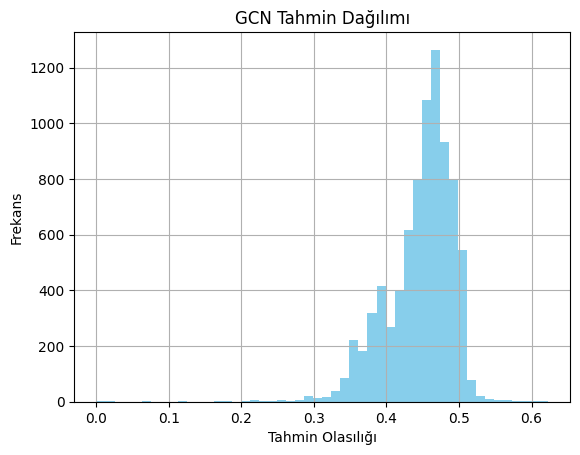

In [52]:
plt.hist(gcn_probs, bins=50, color='skyblue')
plt.title('GCN Tahmin Dağılımı')
plt.xlabel('Tahmin Olasılığı')
plt.ylabel('Frekans')
plt.grid(True)
plt.show()


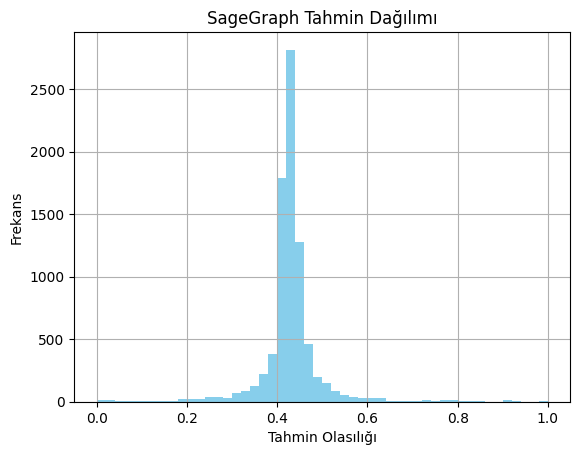

In [53]:
plt.hist(sage_probs, bins=50, color='skyblue')
plt.title('SageGraph Tahmin Dağılımı')
plt.xlabel('Tahmin Olasılığı')
plt.ylabel('Frekans')
plt.grid(True)
plt.show()


### 📊 Tahmin Olasılığı Dağılımı ve Performans Karşılaştırması (GraphSAGE vs. GCN)

Bu grafikler, GraphSAGE ve GCN modellerinin test verisinde ürettiği bağlantı tahmin olasılıklarının dağılımını göstermektedir. Dağılımın genişliği ve yoğunluğu, modelin sınıflar arasında ne kadar ayrım yapabildiğine dair fikir verir.

---

#### 🟢 GraphSAGE

- Tahminlerin çoğu **0.40–0.45** aralığında yoğunlaşmış olsa da, tüm aralığa yayılan bir dağılım gözlenmiştir (0.0–1.0).
- Modele ait olasılık tahminleri hem negatif hem pozitif sınıfa karşı duyarlılık gösteriyor.
- AUC: **0.5841**  
- Accuracy: **0.4454**  
- F1 Score: **0.6063**  
- Best Threshold: **0.26**

📌 **Yorum:**  
GraphSAGE modeli, daha geniş ve dengeli bir tahmin aralığına sahiptir. Bu, threshold optimizasyonu ile daha iyi F1 skoru elde edilmesine olanak tanımıştır. Dağılım simetrik ve anlamlıdır.

---

#### 🔵 GCN

- Tahminler büyük oranda **0.40–0.50** aralığında toplanmıştır.
- 0.5 üzeri tahmin azdır ancak model yine de sınıflar arasında belli bir ayrım başarısı göstermektedir.
- AUC: **0.5597**  
- Accuracy: **0.4539**  
- F1 Score: **0.6030**  
- Best Threshold: **0.36**

📌 **Yorum:**  
GCN modelinin tahmin aralığı daha dar olmasına rağmen, doğru threshold seçimiyle **başarılı bir F1 skoru** elde edilmiştir. Bu, modelin zayıf ayrım gücüne rağmen dengeli sınıfl
